In [1]:
## IMPORT LIBRARIES
import neuropythy as ny
from nilearn import plotting, signal, surface
import nilearn
import glob
import os
import itertools
from itertools import compress
import numpy as np
import pickle
import matplotlib.pyplot as plt
from surfer import Brain
import ipyvolume as ipv
import warnings
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

In [11]:
def get_timings(sub, conditions=('face', 'vehicle'), duration='block'):
    """Get timings from log folder. All the timings are relative to the first non-null Pulse.

    condition:  a tuple comparing 2 or more classes ('male','female','car','bike','rest', 'face','vehicle')
                Faces and vehicles are incopatible with other categories (they can only be compared to each other)

    duration:   stimulus =  stimulus time   (0.05 s)
                trial =     trial time      (1.5 s)
                block =     block time      (30 s)
                cycle =     block time, each block a regressor"""

    valid_conditions = ['male', 'female', 'car',
                        'bike', 'rest', 'face', 'vehicle']
    valid_duration = ['stimulus', 'trial', 'block', 'cycle']
    for condition in conditions:
        if condition not in valid_conditions:
            raise ValueError(
                f'Conditions are not valid - they can be only be {valid_conditions}')
    if (('face' in conditions) or ('vehicle' in conditions)) and (('male' in conditions) or ('female' in conditions) or ('car' in conditions) or ('bike' in conditions) or ('rest' in conditions)):
        raise ValueError(
            'You cannot compare faces and vehicles with other (sub)classes.')
    if len(conditions) <= 1:
        raise ValueError(f'Not enough conditions to compare {len(conditions)}')
    if duration not in valid_duration:
        raise ValueError(f'Duration can be only be {valid_duration}')

    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    import os
    import glob
    import json
    from dateutil import parser
    import numpy as np

    conditions = list(conditions)
    sub_id = int(sub.split('-')[-1])
    func_dir = os.path.join(
        r'E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS', sub, 'func')
    bh_root = r'E:\2exp_fMRI\Exp\Data\Data\BH_data'
    root = os.path.join(bh_root, 's'+str(sub_id))
    log_files = sorted(glob.glob(os.path.join(root, '*run*.log')))
    log_files = [
        log_file for log_file in log_files if 'practice' not in log_file]
    json_files = sorted(glob.glob(os.path.join(func_dir, '*exp*.json')))
    events_list = []
    for run in range(len(log_files)):
        block_idx = 0
        # import LOG data
        df = pd.read_csv(log_files[run], sep='\t', skiprows=3)
        data = df[~df['Subject'].isin(['Picture', 'Event Type'])]

        pulses_data = data[(data['Event Type'] == 'Pulse')
                           & (data['Trial'] != '0')]
        pulses_data = pulses_data.reset_index()
        pulses_time = pulses_data['Time'].values.astype(
            'float') - float(pulses_data['Time'][0])

        # import task data
        task_data = data[data['Event Type'] == 'Picture']
        task_data = task_data.reset_index(drop=True)
        task_time = task_data['Time'].values.astype(
            'float') - float(pulses_data['Time'][0])

        task_end = round(float(task_time[-1]) / 10000, 2)
        task_start = round(float(task_time[0]) / 10000, 2)

        # import JSON data
        with open(json_files[0]) as json_file:
            json_dict = json.load(json_file)

        acquisition_time_raw = [parser.parse(
            timepoint) for timepoint in json_dict['time']['samples']['AcquisitionTime']]
        acquisition_time = [(acquisition_time_raw[i] - acquisition_time_raw[0]
                             ).total_seconds() for i in range(len(acquisition_time_raw))]

        results = pd.DataFrame(columns=('FIRST', 'LAST'),
                               index=('TASK', 'PULSES', 'ACQUISITION'))

        results['FIRST'] = [task_start, round(
            float(pulses_time[0]) / 10000, 2), acquisition_time[0]]
        results['LAST'] = [task_end, round(
            float(pulses_time[-1]) / 10000, 2), acquisition_time[-1]]

        # print(f'\t\t\t##### {sub} - Run {run+1} #####')
        # print(results)
        # print('')

        # prepare the events list
        events = pd.DataFrame(
            columns=('onset', 'duration', 'trial_type', 'orientation'))
        events['onset'] = task_time / 10000
        events['duration'] = task_data['Duration'] / 10000
        events['trial_type'] = task_data['category(str)'].fillna(
            task_data['Code'])
        events['orientation'] = task_data['orientation(str)'].fillna(
            task_data['orientation(str)'][0])
        events['run'] = run+1

        # drop end cycle trials
        events_clean = events.drop(
            events[events['trial_type'].str.contains("end")].index)
        events_clean = events_clean.reset_index(drop=True)
        events_clean['duration'][events_clean['trial_type'] == 'rest'] = 20

        # correct trial duration and merge in blocks if desired
        if (duration == 'trial') | (duration == 'block') | (duration == 'cycle'):
            events_clean['duration'][events_clean['trial_type']
                                     != 'rest'] = 1.5
        if (duration == 'block') | (duration == 'cycle'):
            new_onset = []
            new_duration = []
            new_trial_type = []
            rows = range(events_clean.shape[0])
            block_duration = 0
            new_tsv_row = 0
            onset_idx = 0
            for row in rows:
                if row == len(rows)-1:
                    block_duration += events_clean['duration'][row]
                    new_duration.append(block_duration)
                    if duration == 'block':
                        new_trial_type.append(events_clean['trial_type'][row])
                    else:
                        new_trial_type.append(
                            events_clean['trial_type'][row] + f'_{str(run+1)}_{str(block_idx)}')
                        block_idx += 1
                    new_onset.append(events_clean['onset'][onset_idx])
                else:
                    if events_clean['trial_type'][row] == events_clean['trial_type'][row+1]:
                        block_duration += events_clean['duration'][row]
                    else:
                        block_duration += events_clean['duration'][row]
                        new_duration.append(block_duration)
                        if duration == 'block':
                            new_trial_type.append(
                                events_clean['trial_type'][row])
                        else:
                            new_trial_type.append(
                                events_clean['trial_type'][row] + f'_{str(run+1)}_{str(block_idx)}')
                            block_idx += 1
                        new_onset.append(events_clean['onset'][onset_idx])
                        new_tsv_row += 1
                        block_duration = 0
                        onset_idx = row+1
            orientation = events_clean['orientation'][0]
            events_clean = pd.DataFrame()
            events_clean['onset'] = list(np.around(np.array(new_onset), 1))
            events_clean['duration'] = list(
                np.around(np.array(new_duration), 1))
            events_clean['trial_type'] = new_trial_type
            events_clean['orientation'] = orientation
            events_clean['run'] = run+1

        # convert to faces/vehicles if desired
        if (('face' in conditions) or ('vehicle' in conditions)):
            for i, row in enumerate(events_clean['trial_type']):
                if (row.split('_')[0] == 'male') | (row.split('_')[0] == 'female'):
                    if duration == 'cycle':
                        events_clean['trial_type'][i] = 'face' + \
                            f'{row.split("_")[1]}_{row.split("_")[2]}'
                    else:
                        events_clean['trial_type'][i] = 'face'
                elif (row.split('_')[0] == 'car') | (row.split('_')[0] == 'bike'):
                    if duration == 'cycle':
                        events_clean['trial_type'][i] = 'vehicle' + \
                            f'{row.split("_")[1]}_{row.split("_")[2]}'
                    else:
                        events_clean['trial_type'][i] = 'vehicle'
                elif (row.split('_')[0] == 'rest'):
                    if duration == 'cycle':
                        events_clean['trial_type'][i] = 'rest' + \
                            f'{row.split("_")[1]}_{row.split("_")[2]}'
                    else:
                        events_clean['trial_type'][i] = 'rest'
                    events_clean['duration'][i] = 20
                else:
                    raise ValueError(
                        f'Unexpected trial_type (should be one male,female,car,bike - found {row} instead')

        # select only desired blocks (categories in condition)
        events_clean = events_clean[events_clean.trial_type.str.match(
            "|".join(conditions))]
        events_clean = events_clean.reset_index(drop=True)

        events_list.append(events_clean)
    return events_list


def get_confounds(json_run, tsv_run, pipeline):
    """Summary line.

    This function gets the json and tsv specific for the run and returns
    the confounds pandas dataframe.

    Args:
        json_run (dict): JSON dictionary of the selected run
        tsv_run (DataFrame): TSV pandas DataFrame of the selected run 
        pipeline (str): a string describing the pipeline. The string must 
            include denoising (form: int-str) strategies separated by '_'. 
            Possible strategies:
                HMP - Head motion parameters (6,12,24)
                GS - Global signal (1,2,4)
                Phys - Physiological noise (2,4,8)
                aCompCor - aCompCor (10,50)
                SpikeReg - motion outliers FD > 0.5, DVARS > 1.5
                cosine - Discrete cosine-basis regressors low frequencies -> HPF

    Returns:
        bool: pandas.DataFrame of selected regressors

    """
    import itertools
    import pandas as pd
    pipeline_splits = pipeline.split('_')
    selected_keys = []
    for pipeline_split in pipeline_splits:
        try:
            conf_num, conf_split = pipeline_split.split('-')
        except:
            conf_split = pipeline_split
        if conf_split == 'Null':
            selected_keys = []
        if conf_split == 'HMP':  # Head Motion Parameters(6, 12 or 24)
            if int(conf_num) % 6 != 0:
                raise ValueError(
                    'Head Motion Parameters must be a multiple of 6 (rot_x,y,z; trans_x,y,z)')
            hmp_id = int(conf_num) // 6
            if hmp_id > 0:
                selected_keys.append(
                    ['rot_x', 'rot_y', 'rot_z', 'trans_x', 'trans_y', 'trans_z'])
            if hmp_id > 1:
                selected_keys.append(['rot_x_derivative1', 'rot_y_derivative1', 'rot_z_derivative1',
                                      'trans_x_derivative1', 'trans_y_derivative1', 'trans_z_derivative1'])
            if hmp_id > 2:
                selected_keys.append(['rot_x_power2', 'rot_y_power2', 'rot_z_power2', 'trans_x_power2', 'trans_y_power2', 'trans_z_power2', 'rot_x_derivative1_power2',
                                      'rot_y_derivative1_power2', 'rot_z_derivative1_power2', 'trans_x_derivative1_power2', 'trans_y_derivative1_power2', 'trans_z_derivative1_power2'])
        if conf_split == 'GS':  # Global Signal (raw, derivative, power)
            if int(conf_num) > 4:
                raise ValueError('Global signal must be <= 4')
            gs_id = int(conf_num)
            if gs_id > 0:
                selected_keys.append(['global_signal'])
            if gs_id > 1:
                selected_keys.append(['global_signal_derivative1'])
            if gs_id > 2:
                selected_keys.append(
                    ['global_signal_derivative1_power2, global_signal_power2'])
        # Physiological Noise (raw, derivative, power)
        if conf_split == 'Phys':
            if int(conf_num) % 2 != 0:
                raise ValueError(
                    'Phisiological regressors must be multiple of 2 (WM, CSF)')
            phys_id = int(conf_num) // 2
            if phys_id > 0:
                selected_keys.append(['white_matter', 'csf'])
            if phys_id > 1:
                selected_keys.append(
                    ['white_matter_derivative1', 'csf_derivative1'])
            if phys_id > 2:
                selected_keys.append(['white_matter_derivative1_power2',
                                      'csf_derivative1_power2', 'white_matter_power2', 'csf_power2'])
        # aCompCor (10: first 5 for each mask, 50: 50% of variance for each mask)
        if conf_split == 'aCompCor':
            csf_50_dict = {key: value for key, value in json_run.items() if (('Mask' in value) and (
                value['Mask'] == 'CSF') and (value['Method'] == 'aCompCor') and ('dropped' not in key))}
            wm_50_dict = {key: value for key, value in json_run.items() if (('Mask' in value) and (
                value['Mask'] == 'WM') and (value['Method'] == 'aCompCor') and ('dropped' not in key))}
            if (int(conf_num) != 10) and (int(conf_num) != 50):
                raise ValueError(
                    'aCompCorr can only be 10 (5 highest for each mask) or 50 (50% variance for each mask)')
            if int(conf_num) == 10:
                csf_10 = sorted(list(csf_50_dict.keys()))[0:5]
                wm_10 = sorted(list(wm_50_dict.keys()))[0:5]
                selected_keys.append(wm_10)
                selected_keys.append(csf_10)
            elif int(conf_num) == 50:
                csf_50 = list(csf_50_dict.keys())
                wm_50 = list(wm_50_dict.keys())
                selected_keys.append(wm_50)
                selected_keys.append(csf_50)
        if conf_split == 'cosine':
            cosine_keys = [key for key in tsv_run.columns if 'cosine' in key]
            selected_keys.append(cosine_keys)
        if conf_split == 'SpikeReg':
            motion_outlier_keys = [
                key for key in tsv_run.columns if 'motion_outlier' in key]
            selected_keys.append(motion_outlier_keys)
    selected_keys = list(itertools.chain.from_iterable(selected_keys))
    confounds_df = tsv_run[tsv_run.columns.intersection(selected_keys)].copy()
    return confounds_df

def plot_roi_avg_tuple(roi_lists, events, selected_run = None):
    sns.set_style('whitegrid')
    sns.set_context("paper")
    fig_data = pd.DataFrame(None, columns = ('timepoint','signal', 'run', 'low_pass'))
    signal_run = []
    run_idx = []
    line_idx = []
    timepoint_idx = []
    for ii, pl_data in enumerate(roi_lists):
        signal_run.append(list(itertools.chain.from_iterable([np.average(run, axis = 1) for run in pl_data])))
        for i, run in enumerate(pl_data):
                for j, tp in enumerate(run):
                    run_idx.append(i+1)
                    timepoint_idx.append(j * 2)
                    line_idx.append(ii)
    ymin = -2 # min([np.amin(run) for run in pl_data])
    ymax = 2 # max([np.amax(run) for run in pl_data])
    fig_data['signal'] = list(itertools.chain.from_iterable(signal_run))
    fig_data['run'] = run_idx
    fig_data['timepoint'] = timepoint_idx
    fig_data['low_pass'] = line_idx 
    if selected_run is not None:
        fig_data = fig_data[fig_data['run'] == selected_run]
    fig = sns.lineplot(data = fig_data, x = 'timepoint', y = 'signal', hue = 'low_pass')
    fig.xaxis.set_ticks(events[0]['onset'].values.astype(int) + 8)
    if selected_run is not None:
        fig.xaxis.set_ticklabels(events[selected_run - 1]['trial_type'].values.astype(str), rotation = 30)
    else:
        fig.set_xticklabels(labels = events[0]['onset'].values.astype(int) + 8, rotation = 30)
    fig.set(ylim=(ymin, ymax))
    # set alpha for marker (index 0) and for the rest line (idx 3-6) 
    fig.get_children()[1]._alpha = 0.6
    fig.get_children()[1]._color = (125/225,25/225,0)
    fig.get_children()[0]._alpha = 0.7
    fig.get_children()[0]._color = (0,125/225,125/225)
    return fig


In [3]:
## POINT TO THE RIGHT DRECTORIES
root = os.path.abspath(r'E:\2exp_fMRI\Exp\Data\Data\fmri\BIDS')
freesurfer_path = os.path.join(root, 'derivatives', 'freesurfer')
masks_root = os.path.join(root, 'derivatives', 'masks','pickled')
out_root = os.path.join(root, 'derivatives', 'masks','new')

ny.config['freesurfer_subject_paths'] = freesurfer_path

In [4]:
## IMPORT OR COMPUTE FOVEAL AND PERIPHERAL RETINOTOPIC MAPS
## (MAPS WERE ESTIMATED PREVIOUSLY BASED ON SUBJECT'S SURFACE ANATOMY, AFTER FREESURFER RECON-ALL)
## (A SIMILAR BAYESIAN METHOD CAN BE USED TO IMPROVE RETINOTOPIC MAPPING WHEN RETINOTOPIC DATA IS AVAILABE)

# DEFINE SUBJECT AND SESSION FILE (PRECOMPUTED MAPS)
subject = 'sub-14'
session = os.path.join(root, 'derivatives', 'masks','pickled', (subject + '.pkl'))

# IMPORT SUBJECT'S SURFACE FROM FREESURFER AS TEMPLATE
sub = ny.freesurfer_subject(os.path.join(freesurfer_path, subject))

template_names = sorted(sub.images)
template_image = sub.images['brain'] # raw: T1, brain: freesurfer
template_image = ny.image_clear(template_image)    

# IMPORT THE PRECOMPUTED MAPS (OR GENERATE NEW MAPS IF THEY ARE NOT FOUND)
try:
    # Look for precomputed sessions
    with open(session, 'rb') as f:  
        data = pickle.load(f)
    lh_visual = {'visual_area': data[0], 'polar_angle': data[1], 'eccentricity': data[2]}
    rh_visual = {'visual_area': data[3], 'polar_angle': data[4], 'eccentricity': data[5]}
    print(f'STEP: Retinotopic variables loaded for {subject}')
    
except:
    # calculate varea, eccen, and angle using the Benson14 Atlas
    print(f'STEP: No precomputed variables found for {subject}. Generating new retinotopic map')
    (lh_visual, rh_visual) = ny.vision.predict_retinotopy(sub = sub, template = 'benson14', registration = 'fsaverage', sym_angle = False, names = 'properties')
    print(f'STEP:Retinotopic map generated for {subject}.')

# AND LOAD THEM IN TWO DICTIONARIES FOR EASY ACCESS
lh_visual = {'visual_area': data[0],
             'polar_angle': data[1], 'eccentricity': data[2]}
rh_visual = {'visual_area': data[3],
             'polar_angle': data[4], 'eccentricity': data[5]}

# IN THE ORIGINAL IMPLEMENTATION, LH AND RH ARE SIMMETRICAL (BOTH POSITIVE POLAR ANGLE)
# SO WE NEED TO CONVERT RH POLAR ANGLE TO NEGATIVE
rh_visual['polar_angle'] = rh_visual['polar_angle'] * -1


STEP: Retinotopic variables loaded for sub-14


In [5]:
## NOW LET'S GENERATE THE RETINOTOPIC MASKS FOR FOVEAL AND PERIPHERAL STIMULI WITH GIVEN RADIUS AND ECCENTRICITY:

# HERE WE DEFINE RADII SIZE 
fov_radius = 4
per_radius = 1

# HERE WE GENERATE THE FOVEAL MAPS (VISUAL_AREA = 1, RADIUS = 4 ,CENTERED AT THE FOVEA) AND MERGE HEMISPHERES
roi_fov_lh = (lh_visual['visual_area'] == 1) & (lh_visual['eccentricity'] <= fov_radius)
roi_fov_rh = (rh_visual['visual_area'] == 1) & (rh_visual['eccentricity'] <= fov_radius)

# HERE WE CONVERT THE POLAR ANGLES FROM 'VISUAL' (0 DEG IS THE UPPER VERTICAL MERIDIAN,
# POSITIVE VALUES CLOCKWISE ON THE RIGHT VISUAL FIELD -> LEFT HEMISPHERE) TO 'CARTESIAN' COORDINATES
# (X, Y, EXPRESSED IN DEGREES)
(lh_geo_x, lh_geo_y) = ny.as_retinotopy(lh_visual, 'cartesian')
(rh_geo_x, rh_geo_y) = ny.as_retinotopy(rh_visual, 'cartesian')
              
# NOW RH_GEO_X HAS NEGATIVE VALUES (LEFT VISUAL FIELD) AND LH_GEO_X POSITIVE ONES (RIGHT VISUAL FIELD),
# SO WE CAN DEFINE VISUAL FIELD POSITIONS IN CARTESIAN COORDINATES FOR THE PERIPHERAL ROIS. WE HAVE
# TWO PAIRS OF STIMULI: NORMAL STIMULI (LEFT_DOWN, RIGHT_UP) AND INVERTED STIMULI (LEFT_UP, RIGHT_DOWN)
# AT 7 DEGREES ECCENTRICITY AND 1 DEGREE RADIUS. WITH SOME TRIGONOMETRY WE CAN FIND THEIR POSITION IN CARTESIN COORDINATES...
(stim1_normal_x, stim1_normal_y) = (-4.98, -4.98)
(stim2_normal_x, stim2_normal_y) = (+4.98, +4.98)
(stim1_inverted_x, stim1_inverted_y) = (-4.98, +4.98)
(stim2_inverted_x, stim2_inverted_y) = (+4.98, -4.98)
              
# ... AND GENERATE A RETINOTOPIC MASK FOR EACH PAIR OF STIMULI
roi_per_normal_rh = (rh_visual['visual_area'] == 1) & (np.sqrt((rh_geo_x - stim1_normal_x)**2 + (rh_geo_y - stim1_normal_y)**2) <= per_radius)
roi_per_normal_lh = (lh_visual['visual_area'] == 1) & (np.sqrt((lh_geo_x - stim2_normal_x)**2 + (lh_geo_y - stim2_normal_y)**2) <= per_radius)
roi_per_inverted_rh = (rh_visual['visual_area'] == 1) & (np.sqrt((rh_geo_x - stim1_inverted_x)**2 + (rh_geo_y - stim1_inverted_y)**2) <= per_radius)
roi_per_inverted_lh = (lh_visual['visual_area'] == 1) & (np.sqrt((lh_geo_x - stim2_inverted_x)**2 + (lh_geo_y - stim2_inverted_y)**2) <= per_radius)

# LET'S CHECK IF EVERYTHING WENT AS EXPECTED: 
if 0 in (sum(roi_fov_rh), sum(roi_fov_lh), sum(roi_per_normal_rh), sum(roi_per_normal_lh), sum(roi_per_inverted_rh), sum(roi_per_inverted_lh)):
    # IF ANY MASK CONTAINS 0 VERTICES (PERHAPS WE DID SOMETHING WRONG ) RAISE AN ERROR
    raise ValueError('One or more ROI have 0 vertices.')
else:
    # ELSE, PRINT ROIS INFO (VOXELS IN EACH ROI)... 
    roi_info = pd.DataFrame(columns=('LH', 'RH'),
                            index=('FOV', 'NORM', 'INV'))
    roi_info['LH'] = [sum(roi_fov_lh), sum(
        roi_per_normal_lh), sum(roi_per_inverted_lh)]
    roi_info['RH'] = [sum(roi_fov_rh), sum(
        roi_per_normal_rh), sum(roi_per_inverted_rh)]
    print('#### ROI INFO ####\n', roi_info)



#### ROI INFO ####
         LH    RH
FOV   1055  1126
NORM    29    32
INV     50    25


In [6]:
## NOW LET'S VISUALIZE OUR ROIS:
## LEFT HEMI: FOVEAL = GREEN, NORMAL = BLUE, INVERTED = RED

# ASSIGN COLOR CODES
all_rois_lh = (np.array(roi_fov_lh) * 1) + (np.array(roi_per_normal_lh) * 2) + (np.array(roi_per_inverted_lh) * 3)

# AND VISUALIZE ON THE INFLATED SURFACE
ny.cortex_plot(sub.lh.surfaces['inflated'],
               color=all_rois_lh,
               mask=(all_rois_lh > 0),
               cmap = 'hsv',
               alpha = 0.7)

ipv.show()

C:\Users\45027900\Anaconda3\envs\newbids\lib\site-packages\neuropythy\graphics\core.py:1282: UserWarning: neuropythy: NOTE: due to a bug in ipyvolume, camera views cannot currently be set by neuropythy; however, if you click the reset (home) button in the upper-left corner of the figure, the requested view will be fixed.
  ' be set by neuropythy; however, if you click the reset (home) button in' +


In [7]:
## RIGHT HEMI: FOVEAL = GREEN, NORMAL = BLUE, INVERTED = RED

# ASSIGN COLOR CODES
all_rois_rh = (np.array(roi_fov_rh) * 1) + (np.array(roi_per_normal_rh) * 2) + (np.array(roi_per_inverted_rh) * 3)

# VISUALIZE
ny.cortex_plot(sub.rh.surfaces['inflated'],
               color=all_rois_rh,
               mask=(all_rois_rh > 0),
               cmap = 'hsv',
               alpha = 0.7)

ipv.show()

In [17]:
## NOW LET'S USE THESE MASKS TO EXTRACT AND VISUALIZE ACTIVATIONS IN OUR ROIS

# FIRST THINGS FIRST, LET'S DEFINE OUR FOLDERS AND MAIN VRIABLES:
bids_root = os.path.abspath(r'D:\Andrea\fov\BIDS')
fmriprep_root = os.path.join(bids_root, 'derivatives', 'fmriprep_fsaverage', 'fmriprep')
events_root = os.path.join(bids_root, 'derivatives', 'events', 'all')

sub_id = 14
sub = 'sub-' + str(sub_id).zfill(2)
conditions = ('bike','car','female','male', 'rest')

# IMPORT FUNCTIONAL GIFTI DATA
giftis_files = sorted(glob.glob(os.path.join(fmriprep_root, sub, 'func', '*exp*fsnative*.func.gii')))
time_series = [surface.load_surf_data(gifti).T for gifti in giftis_files]

# IMPORT EVENTS (FROM RAW LOGS)
events = get_timings(sub, conditions, duration='block')
orientation = events[0]['orientation'][0]

# IMPORT NUISANCE REGRESSORS FROM FMRIPREP 
# HERE THE CHOICE OF STRATEGIES IS COMPLETELY ARBITRARY (SEE GET_CONFOUNDS FUNCTION FOR MORE INFO)
pipelines = ['6-HMP_SpikeReg_cosine',
             '6-HMP_8-Phys_SpikeReg_cosine',
             '24-HMP_SpikeReg_cosine', 
             '6-HMP_4-GS_8-Phys_SpikeReg_cosine', 
             '10-aCompCor_SpikeReg_cosine', 
             '24-HMP_8-Phys_SpikeReg_cosine']

conf_tsv_files = sorted(glob.glob(os.path.join(fmriprep_root, sub, 'func', '*exp*confounds*tsv')))
conf_tsvs = [pd.read_csv(conf_tsv_file, sep='\t').fillna(0) for conf_tsv_file in conf_tsv_files]

conf_json_files = sorted(glob.glob(os.path.join(fmriprep_root, sub, 'func', '*exp*confounds*json')))
conf_jsons = []
for conf_json_file in conf_json_files:
    with open(conf_json_file) as json_file:
        conf_jsons.append(json.load(json_file))

confounds = {key: [] for key in pipelines}
for pipeline in pipelines:
    for run_id in range(len(conf_tsvs)):
        confounds[pipeline].append(get_confounds(conf_jsons[run_id], conf_tsvs[run_id], pipeline))


In [18]:
## HERE WE IMPORT THE TIMESERIES AND ASSIGN THEM TO THE ROIS

# get vertices lists
vertices_fov_lh = list(np.where(roi_fov_lh)[0])
vertices_fov_rh = list(np.where(roi_fov_rh)[0])
vertices_per_normal_lh = list(np.where(roi_per_normal_lh)[0])
vertices_per_normal_rh = list(np.where(roi_per_normal_rh)[0])
vertices_per_inverted_lh = list(np.where(roi_per_inverted_lh)[0])
vertices_per_inverted_rh = list(np.where(roi_per_inverted_rh)[0])

# Raise an error if the ROIs overlap (just double-checking that everythin is correct)
if (not set(vertices_fov_lh).isdisjoint(vertices_per_normal_lh)) | (not set(vertices_fov_lh).isdisjoint(vertices_per_inverted_lh)) | (not set(vertices_per_normal_lh).isdisjoint(vertices_per_inverted_lh)):
    raise ValueError('There is an overlap between foveal and peripheral vertices in the LEFT hemisphere')
if (not set(vertices_fov_rh).isdisjoint(vertices_per_normal_rh)) | (not set(vertices_fov_rh).isdisjoint(vertices_per_inverted_rh)) | (not set(vertices_per_normal_rh).isdisjoint(vertices_per_inverted_rh)):
    raise ValueError('There is an overlap between foveal and peripheral vertices in the RIGHT hemisphere')
print('There is no overlap between foveal, peripheral normal and peripheral inverted ROIs\n')

# get masked time series
ts_fov_lh = []
ts_fov_rh = []
ts_per_normal_lh = []
ts_per_normal_rh = []
ts_per_inverted_lh = []
ts_per_inverted_rh = []

for i,time_serie in enumerate(time_series):
    if i % 2 == 0: # if the time_serie is left hemisphere
        ts_fov_lh.append(np.array([list(compress(time_serie[timepoint], roi_fov_lh)) for timepoint in range(len(time_serie))]))
        ts_per_normal_lh.append(np.array([list(compress(time_serie[timepoint], roi_per_normal_lh)) for timepoint in range(len(time_serie))]))
        ts_per_inverted_lh.append(np.array([list(compress(time_serie[timepoint], roi_per_inverted_lh)) for timepoint in range(len(time_serie))]))
    else:
        ts_fov_rh.append(np.array([list(compress(time_serie[timepoint], roi_fov_rh)) for timepoint in range(len(time_serie))]))
        ts_per_normal_rh.append(np.array([list(compress(time_serie[timepoint], roi_per_normal_rh)) for timepoint in range(len(time_serie))]))
        ts_per_inverted_rh.append(np.array([list(compress(time_serie[timepoint], roi_per_inverted_rh)) for timepoint in range(len(time_serie))]))

## MERGE RH AND LH horizontally and assign to stim/opp roi
ts_fov = [np.concatenate((ts_fov_lh[run], ts_fov_rh[run]), axis = 1) for run in range(len(ts_fov_lh))]
if orientation == 'inverted':
    ts_per_stim = [np.concatenate((ts_per_inverted_lh[run], ts_per_inverted_rh[run]), axis = 1) for run in range(len(ts_per_inverted_lh))]
    ts_per_opp = [np.concatenate((ts_per_normal_lh[run], ts_per_normal_rh[run]), axis = 1) for run in range(len(ts_per_normal_lh))]
elif orientation == 'normal':
    ts_per_opp = [np.concatenate((ts_per_inverted_lh[run], ts_per_inverted_rh[run]), axis = 1) for run in range(len(ts_per_inverted_lh))]
    ts_per_inv = [np.concatenate((ts_per_normal_lh[run], ts_per_normal_rh[run]), axis = 1) for run in range(len(ts_per_normal_lh))]



There is no overlap between foveal, peripheral normal and peripheral inverted ROIs



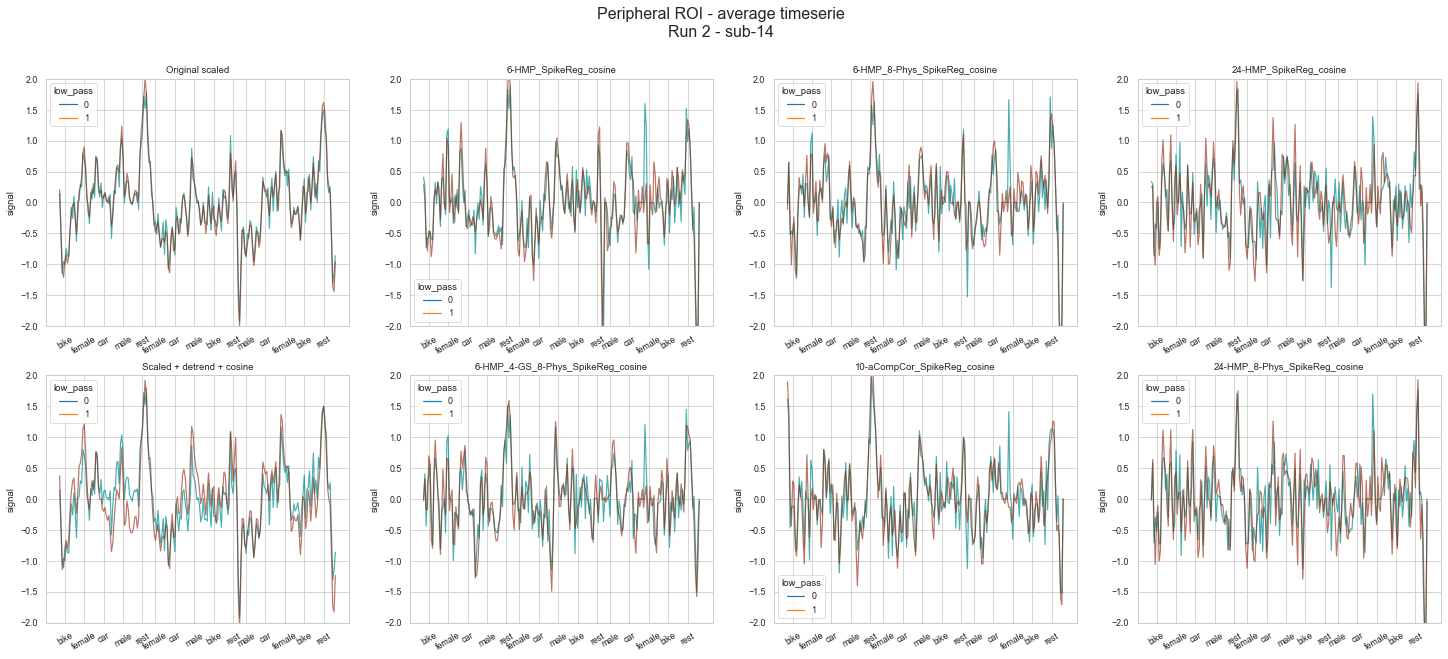

In [21]:
## NOW THE FUN PART: LET'S CLEAN AND PLOT OUR DATA! WE WANT ALSO TO COMPARE DIFFERENT DENOISING STRATEGIES

# SET DENOISING PARAMETERS
# HPF: 128 (SPM default); LPF: 0.15 (neuronal signal is below 6-8 cycle))
# SINCE WE ARE USING THE COSINE REGRESSORS WE DON'T WANT TO DETREND OR APPLY HPF (IT WOULD RE-ADD SOME NOISE)
scan_time = ts_fov[0].shape[0] * 2
bold_peak = 6.6

# detrend = True
# hpf = round(1/128, 3)
lpf = round(((scan_time/bold_peak) / scan_time), 3)
cosine_conf = [get_confounds(conf_jsons[run_id], conf_tsvs[run_id], 'cosine') for run_id in range(len(conf_tsvs))]

# DENOISE AND PLOT!
run_id = 1

sns.set_style('whitegrid')
sns.set_context("paper")

plt_grid = plt.figure(figsize=(25,10))
plt_grid.suptitle(f'Peripheral ROI - average timeserie\nRun {str(run_id + 1)} - {sub}', fontsize=16)

plt.subplot(241)
plt.title('Original scaled')
ts_per_stim_scaled = [signal.clean(run, t_r=2, detrend=False) for run in ts_per_stim]
ts_per_stim_scaled_lpf_cosine = [signal.clean(run, t_r=2, detrend=False, low_pass = lpf) for run in ts_per_stim]
plot_roi_avg_tuple((ts_per_stim_scaled,ts_per_stim_scaled_lpf_cosine), events, selected_run = run_id+1).set_xlabel('')

plt.subplot(245)
plt.title('Scaled + detrend + cosine')
ts_per_stim_cos = [signal.clean(run, t_r=2, detrend=True, confounds = cosine_conf[run_id]) for run in ts_per_stim]
ts_per_stim_cos_lpf = [signal.clean(run, t_r=2, detrend=True, confounds = cosine_conf[run_id], low_pass = lpf) for run in ts_per_stim]
plot_roi_avg_tuple((ts_per_stim_scaled,ts_per_stim_cos_lpf), events, selected_run = run_id+1).set_xlabel('')

sub_plt_id = 241
for pipeline in pipelines:
    sub_plt_id += 1
    if sub_plt_id == 245:
        sub_plt_id += 1
    plt.subplot(sub_plt_id)
    plt.title(f'{pipeline}')
    ts_per_stim_denoised = [signal.clean(run, t_r=2, detrend=False, confounds = confounds[pipeline][run_id]) for run in ts_per_stim]
    ts_per_stim_denoised_lpf = [signal.clean(run, t_r=2, detrend=False, confounds = confounds[pipeline][run_id], low_pass = lpf) for run in ts_per_stim]
    plot_roi_avg_tuple((ts_per_stim_denoised,ts_per_stim_denoised_lpf), events, selected_run = run_id+1).set_xlabel('')

plt.show()
